# Lethal Mutagenesis Simulation (Ben Parsing)

In [5]:
using Markdown
using InteractiveUtils

In [6]:
using CSV, Random, Distributions, StatsBase, DataFrames, Plots
#Parameters

# Julian Lethal Mutagenesis Model

## Initialization

In [7]:
#Random.seed!(202020)

## Constants
Let's start by defining the constants and parameters in the model:
(Note the `@with_kw` macro is from Parameters.jl)
"""

In [84]:
# physical constants
kt_boltzmann::Float64 = 0.001987204118 * (273.15+37)
ΔΔG::Normal{Float64} = Normal(1.0, 1.7)

# fixed parameters
G::Int = 10 # number_of_genes
sim_length::Int = 500 # number of generations 500
F::Float64 = -5.0 # initial_free_energy (of all proteins)

# variable parameters
U::Poisson{Float64} = Poisson(2.4) # mutation_rate - 2.4
L::Float64 = 0 # lethal_fraction - 0.2
N::Int = 2000 # start_popsize
K::Int = 2000 # carrying_capacity
R::Int = 10 # fecundity - 4
Rep::Int = 1 #Replicate No.
#description::String # manual entry
#replicate::Char # manual entry

# new variable parameters to control logistic type function
min_success_rate = 0.1
max_success_rate = 0.9
success_exponent = 2

2

## Struct and Methods
Next let's specify a Virus struct:

In [32]:
mutable struct Virus
	μ_counts::Vector{Int64}
	ΔG_list::Vector{Float64}
	fitness::Float64
    zombie::Bool
end

And then a function to modify the fitness of a virus:

In [33]:
function update_fitness!(virus::Virus)
	# I could check if any ΔG value > 1
    virus.fitness = prod([1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in virus.ΔG_list])
end

update_fitness! (generic function with 1 method)

Note that this is a little approximate:

In [34]:
start_fitness = prod([1 / (1 + ℯ^(ΔG/kt_boltzmann)) for ΔG in fill(F, G)])

0.997007308816621

In [35]:
quentin = Virus(zeros(Int, G), fill(F, G), start_fitness, false)

Virus([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], 0.997007308816621, false)

In [36]:
quentin.zombie

false

In [37]:
quentin.fitness

0.997007308816621

In [38]:
update_fitness!(quentin)

0.997007308816621

And now a function to mutate a virus:

In [39]:
function mutate!(virus::Virus)
	number_of_mutations = only(rand(U, 1))
	ΔΔG_values = rand(ΔΔG, number_of_mutations)
	mutgene_coord = rand((1:G), number_of_mutations)
	for (index, gene_id) in enumerate(mutgene_coord)
		virus.μ_counts[gene_id] += 1
		virus.ΔG_list[gene_id] = virus.ΔG_list[gene_id] + ΔΔG_values[index]
		if only(rand(Float64, 1)) < L
			virus.fitness = 0
		end
	end
	( virus.fitness > 0  ) && ( update_fitness!(virus) )
    if virus.fitness <= 0 # make me efficient!
        virus.zombie = true
    end
    return virus.fitness
end

mutate! (generic function with 1 method)

In [40]:
mutate!(quentin)

0.997007308816621

In [41]:
quentin

Virus([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], 0.997007308816621, false)

And now a function to reproduce a virus:

In [42]:
function reproduce(parent::Virus)
    sprog = deepcopy(parent)
    mutate!(sprog)
	return sprog
end

reproduce (generic function with 1 method)

In [43]:
terrence = reproduce(quentin)

Virus([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0, -5.0], 0.997007308816621, false)

In [44]:
terrence.fitness

0.997007308816621

## Helper Functions
Now let's develop some helper functions.

Initialize a population:

In [45]:
function initialize_population()
	initial_population = [Virus(zeros(Int, G), fill(F, G), start_fitness, false) for _ in 1:N]
    return initial_population
end

initialize_population (generic function with 1 method)

Derive relative fitnesses:

In [46]:
function get_weights(populace)
    weights = [v.fitness for v in populace]
    return Weights(weights/sum(weights))
end

get_weights (generic function with 1 method)

Snap to integer family size probabilistically:

In [47]:
function probabilistic_round(number)
    frac = abs(number - floor(number))
    if only(rand(Float64, 1)) < frac
        return ceil(Int, number)
	end
    return floor(Int, number)
end

probabilistic_round (generic function with 1 method)

Initialize a report DataFrame with named columns but no data:

In [48]:
function initialize_report()
	report = DataFrame(psiz = Int[], q1fit = Float64[], meanfit = Float64[],
        q2fit = Float64[], maxfit = Float64[], minfree = Float64[], 
		meanfree = Float64[], maxfree = Float64[], minmut = Float64[], 
		meanmut = Float64[], maxmut = Float64[])
	return report
end

initialize_report (generic function with 1 method)

Update report with a row representing data from input population instance (here called populace):

In [49]:
function report_update!(populace, report)
    push!(report, 
		[length(populace), #psiz
		quantile([v.fitness for v in populace], 0.25), #q1fit
		mean([v.fitness for v in populace]), #meanfit
	    median([v.fitness for v in populace]), #q2fit
	    maximum([v.fitness for v in populace]), #maxfit
	    mean([minimum(v.ΔG_list) for v in populace]), #minfree
	    mean([mean(v.ΔG_list) for v in populace]), #meanfree
	    mean([maximum(v.ΔG_list) for v in populace]), #maxfree
	    minimum([sum(v.μ_counts) for v in populace]), #minmut
	    mean([sum(v.μ_counts) for v in populace]), #meanmut
	    maximum([sum(v.μ_counts) for v in populace]), #maxmut
		])
end

report_update! (generic function with 1 method)

Plot a simulation based on the report data and description field:

In [50]:
function plot_simulation(report)
	abscissa = range(1, size(report, 1))
	p1 = plot(abscissa, report.psiz, ylims=(0,maximum(report.psiz)),
		label="pop size", linewidth=3,
		title="A")
	p2 = plot(abscissa, [report.q1fit, report.meanfit, report.q2fit, report.maxfit], 
		label=["Q1 fitness" "mean fitness" "median fitness" "max fitness"], linewidth=3, title="B")
	p3 = plot(abscissa, [report.minfree, report.meanfree, report.maxfree], 
		label=["min ΔG" "mean ΔG" "max ΔG"], 
		linewidth=3, title="C")
	p4 = plot(abscissa, [report.minmut, report.meanmut, report.maxmut],
		label=["min # μ count" "mean # μ" "max # μ"], 
		linewidth=3, title="D")
	plot(p1, p2, p3, p4, titleloc = :left, titlefont = font(20), layout=(2,2), size=(1000, 700))
end

plot_simulation (generic function with 1 method)

## Simulation with Synchronized Generations
Let's construct a simulation in which generations are synchronized and fecundity is a function of R (interpreted as baseline fecundity) and fitness of the focal viral parent. Random culling is carried when the population reaches carrying capacity.

In [51]:
function synchronized_generation(populace, successrate)
	next_generation = []
	for parent in populace
		for r in 1:probabilistic_round(R * successrate * parent.fitness)
			child = reproduce(parent)
			( child.fitness > 0  ) && ( push!(next_generation, child) ) # could be a zombie test
		end
	end
	return next_generation
end

synchronized_generation (generic function with 1 method)

In [68]:
function synchronized_simulation()
	population = initialize_population()
	population_size = N
    #S = (K - N) / K # initial success rate (this would break if K = N)
	report = initialize_report()
	sim_remaining = sim_length
	while sim_remaining > 0
		sim_remaining -= 1
        gencount = sim_length - sim_remaining # only for diagnostics
		S = min_success_rate + (max_success_rate - min_success_rate) * (1 - (min(K, population_size)/K)^success_exponent)
		if gencount <= 5 || sim_remaining % 20 == 0 # can change reporting frequency here
			println("generation:", gencount, "; successrate:", S)
		end
		report_update!(population, report)
		population = synchronized_generation(population, S)
		population_size = length(population)
		
		#if population_size > K
	    #    population = sample(population, K, replace=false)
		    # why calculate when you can set?
	    #    population_size = K
	
		if population_size == 0 # was an elseif
			# they're all dead
			sim_remaining = 0
		end
	end
	return report
end

synchronized_simulation (generic function with 1 method)

generation:1; successrate:0.1
generation:2; successrate:0.10159919999999999
generation:3; successrate:0.20584620000000006
generation:4; successrate:0.1
generation:5; successrate:0.1
generation:20; successrate:0.1
generation:40; successrate:0.6601950000000001
generation:60; successrate:0.11908479999999999
generation:80; successrate:0.6139167999999999
generation:100; successrate:0.1
generation:120; successrate:0.1
generation:140; successrate:0.41515020000000014
generation:160; successrate:0.1
generation:180; successrate:0.48065920000000006
generation:200; successrate:0.1
generation:220; successrate:0.1
generation:240; successrate:0.5541550000000001
generation:260; successrate:0.1
generation:280; successrate:0.1
generation:300; successrate:0.5525752
generation:320; successrate:0.1
generation:340; successrate:0.1
generation:360; successrate:0.5794488
generation:380; successrate:0.1
generation:400; successrate:0.1
generation:420; successrate:0.5446222000000001
generation:440; successrate:0.

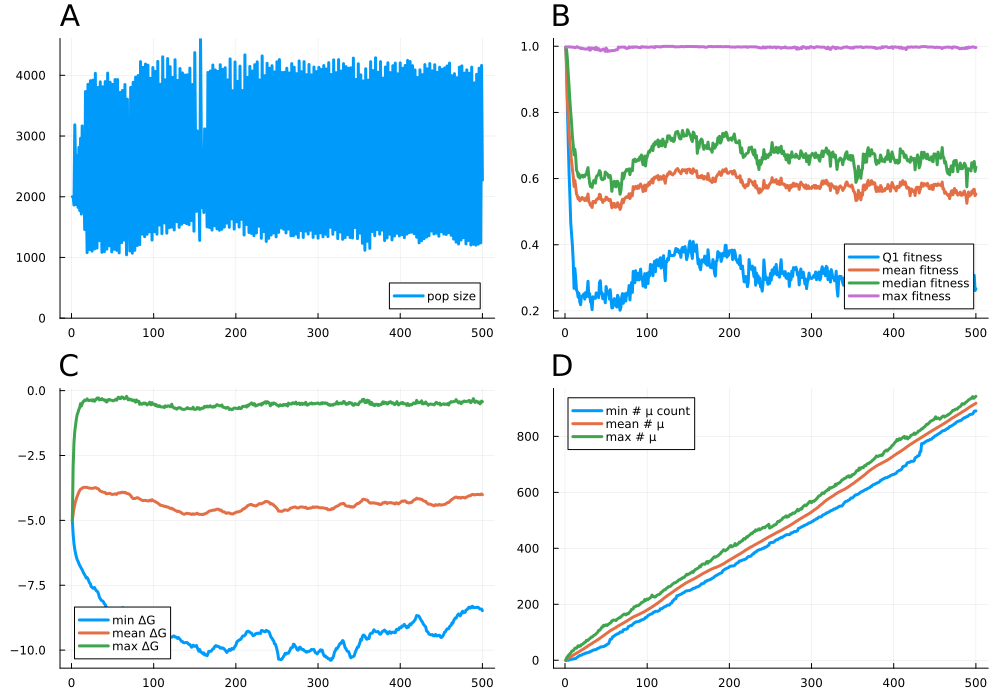

In [85]:
synchronized_report = synchronized_simulation()
plot_simulation(synchronized_report)

In [76]:
function process_simulation(L::Float64, N::Int, Rep::Int)
    cd(joinpath("/Users", "BIO3DICKIB", "Lethal Mutagenesis", "Simulation", "10Genes", "R1", "K200", "Rep2", "U1"))
    
    synchronized_report = synchronized_simulation()
    plot_simulation(synchronized_report)
    
    base_filename = "L$(L)_N$(N)_Rep$(Rep)"
    
    CSV.write("$(base_filename).csv", synchronized_report)
    png("$(base_filename).png")
    
    return nothing
end

process_simulation (generic function with 1 method)

In [28]:
synchronized_report

Row,psiz,q1fit,meanfit,q2fit,maxfit,minfree,meanfree,maxfree,minmut,meanmut,maxmut
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,200,0.997007,0.997007,0.997007,0.997007,-5.0,-5.0,-5.0,0.0,0.0,0.0
2,142,0.994433,0.973366,0.997007,0.997299,-5.09342,-4.91585,-4.2082,0.0,0.640845,3.0
3,92,0.982352,0.966433,0.995708,0.997548,-5.15937,-4.85871,-3.69645,0.0,1.1413,4.0
4,56,0.981265,0.982649,0.992057,0.997025,-5.1445,-4.80336,-3.40709,0.0,1.69643,5.0
5,39,0.97715,0.967721,0.986707,0.997202,-5.3629,-4.76109,-3.12887,0.0,2.41026,6.0
6,28,0.96315,0.957338,0.98321,0.997007,-5.85541,-4.732,-2.80145,0.0,3.14286,7.0
7,14,0.982932,0.928878,0.989941,0.997007,-6.11602,-4.76856,-2.95328,0.0,3.57143,7.0
8,9,0.911411,0.875132,0.983783,0.997007,-6.49308,-4.81,-2.46204,0.0,4.33333,7.0
9,8,0.95583,0.882502,0.982871,0.994193,-6.89807,-4.75984,-2.36074,2.0,5.125,8.0


## Asynchronous (Time-based) Simulation
This simulation picks indviduals as parents proportional to their fitness, while fecundity is always = R. When the population exceed carrying capacity (K) only K parents are picked, otherwise the number of parents is equal to the population size at the beginning of each model step/"generation".

This one takes 28s on my M2 Pro, 32Gb RAM system. We have a lot of growth and numbers expand because viruses sit around not being picked as parents and not inactivating either. It is possibly worth adding an inactivation process in order to implement a form of culling. This would constitute quite a natural system since viruses do fail to find hosts. However, this does alter the meaning of fitness at the margin since a virus can always be picked with low probability by the loop in `asynchronous_modelstep!()`, but inactivation will put paid to this.

## Synchronized Simulation with Soft Selection
This simulation is like the synchronized one except that realized per-capita fecundity is the product of baseline fecundity and relative fitness. Random culling is carried when the population reaches carrying capacity.

## Asynchronous Simulation with Pseudo-Logistic Growth
This simulation is like the asynchronous one except that the baseline fecundity is scaled based on closeness to carrying capacity (as in logistic model but note this is discrete).

## Summary
Really the problem is that fitness has components and our model can include generation time (less is fitter) and fecundity (more is fitter), but an implementation with both risks double counting fitness thereby stripping it of meaning. If fitness is interpreted as lineage growth rate, perhaps we could devise such a combined model, but in order to do this we would need to explictly model latent period and burst size in order to account for their natural limits. We would also need to decide whether mutations can be considered to affect each proportionally. This seems quixotic from a protein model, but we might find data that speaks to mutational effects.

Perhaps we can instead see some limits if we implement an asynchronous model with inactivation (although see my note below the first asynchronous model) and contrast this with a synchronous model with a large carrying capacity (so that this isn't too relevant).

Other forms of realism would include predator-prey feedback.

##### Dead Darlings
We used to include the idea of trimming with the following code when the N>K: `population = wsample(population, get_weights(population), K, replace=false)` but we now realise that this double counts fitness.